## Machine learning on Social Netowrk Graphs

In [1]:
import os
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

default_edge_color = 'gray'
default_node_color = '#407cc9'
enhanced_node_color = '#f5b042'
enhanced_edge_color = '#cc2f04'

In this chapter we will focus on using the techniques outlined in previous chapters to analyze the most-common example of nowadays graphs: Social Networks. In particular we will apply the techniques outlined in previous chapters to investigate the topological properties of the networks, such as 
1. identifying relevant communities as well as 
2. identifying particularly important nodes in the network. 

We will then use node embeddings to leverage on the power of topological information for different tasks, such as link prediction (as a potential recommendation engine for new friends) 

#### Dowload the dataset

First, we need to download the dataset. We will be using the [SNAP Facebook social graph](http://snap.stanford.edu). The dataset was created by collection Facebook user information from survey participants.  More in detail, 10 ego-networks were created from ten users. Each user was asked to identify all the circles (list of friends) to which their friends belong. Then, all the "ego-network" were combined in a single graph.

In [2]:
!curl -O http://snap.stanford.edu/data/facebook_combined.txt.gz
!curl -O http://snap.stanford.edu/data/facebook.tar.gz
!gzip -d -f facebook_combined.txt.gz
!tar -xf facebook.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  213k  100  213k    0     0   138k      0  0:00:01  0:00:01 --:--:--  138k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  714k  100  714k    0     0   287k      0  0:00:02  0:00:02 --:--:--  287k


### Overview of the Dataset

The code above downloads two main files:
*   a text file containing the edge list of the graph. The graph is actually created
*   an archive containing a folder ("facebook") with all the information related to each ego-network



In [3]:
# check the downloaded content
!ls

01_Social_network_analysis.ipynb  facebook.tar.gz  pyproject.toml~
facebook			  poetry.lock	   tmp.txt
facebook_combined.txt		  pyproject.toml   Untitled.ipynb


In [4]:
# take a look at the first lines of the edge list
!head facebook_combined.txt

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10


We can now proceed loading the combined network using networkx. We will also load the nodeId of the 10 "ego-user"

In [5]:
G = nx.read_edgelist("facebook_combined.txt", create_using=nx.Graph(), nodetype=int)

In [6]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910


In [7]:
# Each file in the "facebook" directory is named as nodeId.format
# where nodeId is the id of an ego-user and format is the format of the file
ego_nodes = set([int(name.split('.')[0]) for name in os.listdir("facebook/")])

Let's visualize the network for a deeper understanding

In [8]:
#Create network layout for visualizations
spring_pos = nx.spring_layout(G)

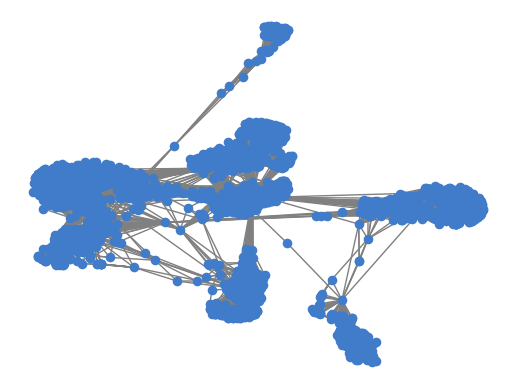

In [9]:
plt.axis("off")
nx.draw_networkx(G, pos=spring_pos, node_color=default_node_color, edge_color=default_edge_color, with_labels=False, node_size=35)

### Network Analysis

In [10]:
def draw_metric(G, dct, spring_pos):
  """ draw the graph G using the layout spring_pos.
      The top 10 nodes w.r.t. values in the dictionary dct
      are enhanced in the visualization """
  top = 10
  max_nodes =  sorted(dct.items(), key = lambda v: -v[1])[:top]
  
  max_keys = [key for key,_ in max_nodes]
  max_vals = [val*300 for _, val in max_nodes]

  plt.axis("off")
  
  nx.draw_networkx(G, 
                   pos=spring_pos, 
                   cmap='Blues', 
                   edge_color=default_edge_color,
                   node_color=default_node_color, 
                   node_size=3,
                   alpha=0.4, 
                   with_labels=False)
  
  nx.draw_networkx_nodes(G, 
                         pos=spring_pos, 
                         nodelist=max_keys, 
                         node_color=enhanced_edge_color,
                         node_size=max_vals)

In [11]:
# betweenness centrality
bC = nx.betweenness_centrality(G)
np.mean(list(bC.values()))

0.0006669573568730229

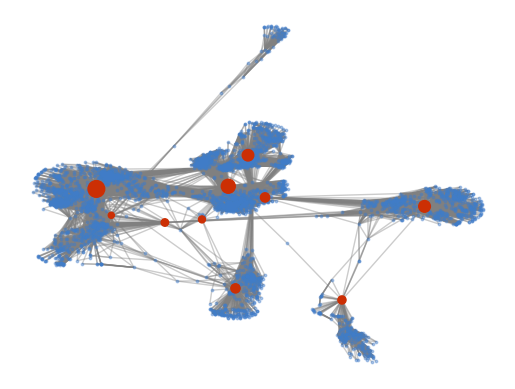

In [12]:
draw_metric(G,bC,spring_pos)

In [13]:
# global efficiency
gE = nx.global_efficiency(G)
print(gE)

0.30657814798734856


In [14]:
# average clustering
aC = nx.average_clustering(G)
print(aC)

0.6055467186200876


In [15]:
# degree centrality
deg_C = nx.degree_centrality(G)
np.mean(list(deg_C.values()))

0.010819963503439287

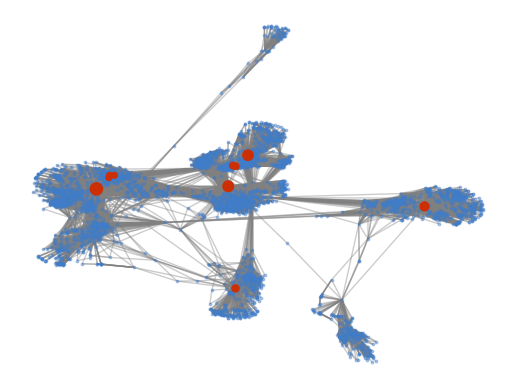

In [16]:
draw_metric(G,deg_C,spring_pos)

In [17]:
# closeness centrality
clos_C = nx.closeness_centrality(G)
np.mean(list(clos_C.values()))

0.2761677635668376

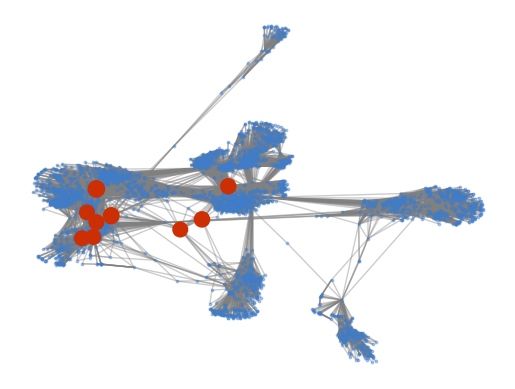

In [18]:
draw_metric(G,clos_C,spring_pos)

In [19]:
# assortativity
assortativity = nx.degree_pearson_correlation_coefficient(G)
assortativity

0.06357722918564916

In [20]:
t = nx.transitivity(G)
t

0.5191742775433075

In [21]:
import networkx.algorithms.community as nx_comm
nx_comm.modularity(G, nx_comm.label_propagation_communities(G))

0.7368407345348218

#### Community detection
In the following cells we will automatically detect communities using infromation from the network topology

0 is in community number 0
107 is in community number 2
3980 is in community number 13
3437 is in community number 12
686 is in community number 14
1684 is in community number 4
1912 is in community number 3
698 is in community number 14
348 is in community number 1
414 is in community number 1


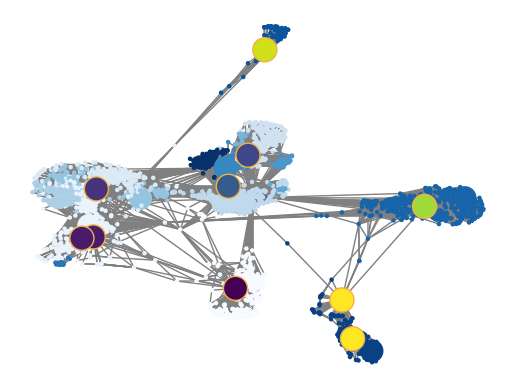

In [22]:
import community

parts = community.best_partition(G)
values = [parts.get(node) for node in G.nodes()]

for node in ego_nodes:
  print(node, "is in community number", parts.get(node))
  
n_sizes = [5]*len(G.nodes())
for node in ego_nodes:
  n_sizes[node] = 250

plt.axis("off")
nx.draw_networkx(G, pos=spring_pos, cmap=plt.get_cmap("Blues"), edge_color=default_edge_color, node_color=values, node_size=n_sizes, with_labels=False)

# enhance color and size of the ego-nodes
nodes = nx.draw_networkx_nodes(G,spring_pos,ego_nodes,node_color=[parts.get(node) for node in ego_nodes])
nodes.set_edgecolor(enhanced_node_color)

### Ego-net analysis

Since the combined network we are analyzing is actually composed by 10 sub-networks (ego-networks), it's interesting to inspect all those subnetwork. In the following cells we will analyze the subnetwork of the ego-user "0".

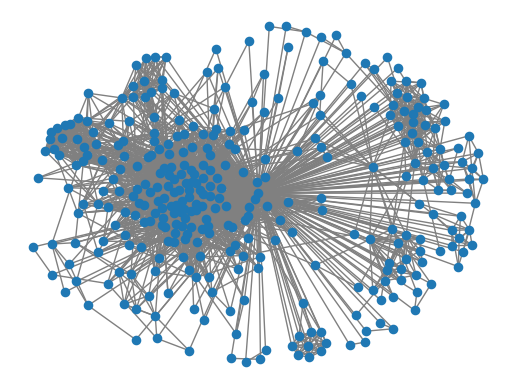

In [23]:
G0 = nx.read_edgelist("facebook/0.edges", create_using=nx.Graph(), nodetype=int)
for node in G0.copy():
  G0.add_edge(0,node)

plt.axis("off")
pos_G0 = nx.spring_layout(G0)
nx.draw_networkx(G0, pos=pos_G0, with_labels=False, node_size=35, edge_color=default_edge_color)

Nodes belonging to each subnetwork are stored in the "facebook" folder under the name nodeId.circles

In [24]:
import pandas as pd
circles = {}

with open("facebook/0.circles") as f_in:
  line = f_in.readline().rstrip().split("\t")
  while line and not '' in line:
    circles[line[0]] = [int(v) for v in line[1:]]
    line = f_in.readline().rstrip().split("\t")

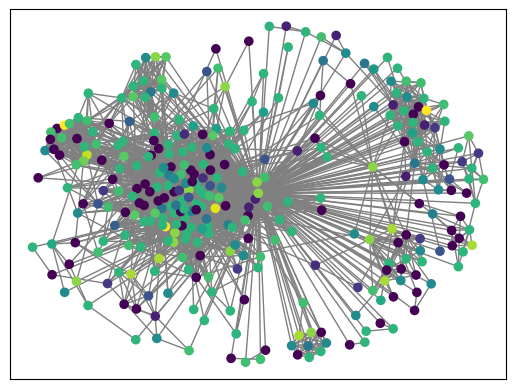

In [25]:
node_colors = [0] * G0.number_of_nodes()
count = 0
for key in circles:
  circle = circles[key]
  for node in circle:
    if node < G0.number_of_nodes():
      node_colors[node] = count
  count += 1

nx.draw_networkx(G0, pos=pos_G0, with_labels=False, node_size=35, node_color=node_colors, edge_color=default_edge_color)

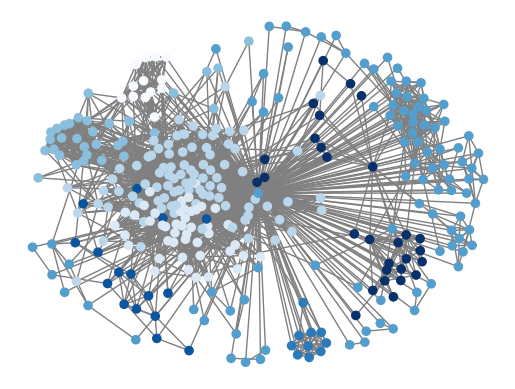

In [26]:
parts = community.best_partition(G0)
values = [parts.get(node) for node in G0.nodes()]

plt.axis("off")
nx.draw_networkx(G0, pos=pos_G0, cmap=plt.get_cmap("Blues"), edge_color=default_edge_color, node_color=values, node_size=35, with_labels=False)

In [27]:
# community found does not reflect the circles
set(parts.values())
len(circles)

24

In [28]:
# a node can be present in more than one list??
for i in circles:
  for j in circles:
    if i != j:
      for n1 in circles[i]:
        for n2 in circles[j]:
          if n1 == n2:
            print(n1, 'present in ',i,'found in', j)
            # assert(False)

54 present in  circle0 found in circle11
298 present in  circle0 found in circle11
97 present in  circle0 found in circle11
183 present in  circle0 found in circle15
173 present in  circle1 found in circle16
125 present in  circle4 found in circle15
55 present in  circle4 found in circle15
122 present in  circle4 found in circle15
280 present in  circle4 found in circle15
236 present in  circle4 found in circle15
69 present in  circle4 found in circle15
258 present in  circle4 found in circle16
23 present in  circle5 found in circle15
52 present in  circle6 found in circle17
93 present in  circle6 found in circle19
17 present in  circle6 found in circle19
137 present in  circle6 found in circle19
343 present in  circle6 found in circle19
326 present in  circle6 found in circle19
214 present in  circle6 found in circle19
115 present in  circle6 found in circle19
312 present in  circle6 found in circle19
41 present in  circle6 found in circle19
20 present in  circle6 found in circle19
28

In [29]:
#@title  
nx.average_shortest_path_length(G0)
nx.global_efficiency(G0)
nx.average_clustering(G0)

np.mean(list(nx.betweenness_centrality(G0).values()))
np.mean(list(nx.closeness_centrality(G0).values()))
np.mean(list(nx.degree_centrality(G0).values()))
nx.degree_pearson_correlation_coefficient(G)
nx.transitivity(G)

import networkx.algorithms.community as nx_comm
nx_comm.modularity(G, nx_comm.label_propagation_communities(G))

0.7368407345348218

### Embeddings for Supervised and Unsupervised Tasks 

We will now proceed with the actual machine learning task. In particular, we will perform an edge prediction task for the Facebook social graph.

#### parse node features

As first, let's load all the features describing each node. This is not a straightforward process and requires a bit of codes, since each subnetwork contains it's own set of features, whose names and values are stored in different files. 

In [30]:
# Adapted from https://github.com/jcatw/snap-facebook

feat_file_name = "feature_map.txt"
feature_index = {}  #numeric index to name
inverted_feature_index = {} #name to numeric index
network = nx.Graph()

def parse_featname_line(line):
  """ used to parse each line of the files containing feature names """
  line = line[(line.find(' '))+1:]  # chop first field
  split = line.split(';')
  name = ';'.join(split[:-1]) # feature name
  index = int(split[-1].split(" ")[-1]) #feature index
  return index, name

def load_features():
  """ 
  parse each ego-network and creates two dictionaries:
      - feature_index: maps numeric indices to names
      - inverted_feature_index: maps names to numeric indices
  """
  import glob
  feat_file_name = 'tmp.txt'
  # may need to build the index first
  if not os.path.exists(feat_file_name):
      feat_index = {}
      # build the index from data/*.featnames files
      featname_files = glob.iglob("facebook/*.featnames")
      for featname_file_name in featname_files:
          featname_file = open(featname_file_name, 'r')
          for line in featname_file:
              # example line:
              # 0 birthday;anonymized feature 376
              index, name = parse_featname_line(line)
              feat_index[index] = name
          featname_file.close()
      keys = feat_index.keys()
      keys = sorted(keys)
      out = open(feat_file_name,'w')
      for key in keys:
          out.write("%d %s\n" % (key, feat_index[key]))
      out.close()

  index_file = open(feat_file_name,'r')
  for line in index_file:
      split = line.strip().split(' ')
      key = int(split[0])
      val = split[1]
      feature_index[key] = val
  index_file.close()

  for key in feature_index.keys():
      val = feature_index[key]
      inverted_feature_index[val] = key

def parse_nodes(network, ego_nodes):
  """
  for each nodes in the network assign the corresponding features 
  previously loaded using the load_features function
  """
  # parse each node
  for node_id in ego_nodes:
      featname_file = open(f'facebook/{node_id}.featnames','r')
      feat_file     = open(f'facebook/{node_id}.feat','r')
      egofeat_file  = open(f'facebook/{node_id}.egofeat','r')
      edge_file     = open(f'facebook/{node_id}.edges','r')

      ego_features = [int(x) for x in egofeat_file.readline().split(' ')]

      # Add ego node features
      network.nodes[node_id]['features'] = np.zeros(len(feature_index))
      
      # parse ego node
      i = 0
      for line in featname_file:
          key, val = parse_featname_line(line)
          # Update feature value if necessary
          if ego_features[i] + 1 > network.nodes[node_id]['features'][key]:
              network.nodes[node_id]['features'][key] = ego_features[i] + 1
          i += 1

      # parse neighboring nodes
      for line in feat_file:
          featname_file.seek(0)
          split = [int(x) for x in line.split(' ')]
          node_id = split[0]
          features = split[1:]

          # Add node features
          network.nodes[node_id]['features'] = np.zeros(len(feature_index))

          i = 0
          for line in featname_file:
              key, val = parse_featname_line(line)
              # Update feature value if necessary
              if features[i] + 1 > network.nodes[node_id]['features'][key]:
                  network.nodes[node_id]['features'][key] = features[i] + 1
              i += 1
          
      featname_file.close()
      feat_file.close()
      egofeat_file.close()
      edge_file.close()

In [31]:
# parse edge features and add them to the networkx nodes
load_features()
parse_nodes(G, ego_nodes)

In [32]:
# check features has been correctly assigned
G.nodes[0]

{'features': array([1., 1., 1., ..., 0., 0., 0.])}

### Link prediction
It's now time for machine learning.
As first, we will be using stellargraph utility function to define a train and test set.
More in detail, TODO

In [33]:
from sklearn.model_selection import train_test_split
from stellargraph.data import EdgeSplitter
from stellargraph import StellarGraph

edgeSplitter = EdgeSplitter(G) 
graph_test, samples_test, labels_test = edgeSplitter.train_test_split(p=0.1, method="global", seed=24)

edgeSplitter = EdgeSplitter(graph_test, G) 
graph_train, samples_train, labels_train = edgeSplitter.train_test_split(p=0.1, method="global", seed=24)

2024-06-25 20:21:13.886590: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-25 20:21:13.886605: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-06-25 20:21:14.774001: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-06-25 20:21:14.774018: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-25 20:21:14.774029: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pelican): /proc/driver/nvidia/version does not exist
2024-06-25 20:21:14.774220: I tensorflow/core/platform/cpu_feature_gu

** Sampled 8823 positive and 8823 negative edges. **
** Sampled 7941 positive and 7941 negative edges. **


We will be comparing three different methods for predicting missing edges:
- Method1: node2vec will be used to learn a node embedding. Such embeddings will be used to train a Random Forest classifier in a supervised manner
- Method2: graphSAGE (with and without features) will be used for link prediction
- Method3: hand-crafted features will be extracted and used to train a Random Forest classifier

##### node2vec


In [34]:
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder 
from stellargraph.data import EdgeSplitter 

node2vec = Node2Vec(graph_train) 
model = node2vec.fit() 
edges_embs = HadamardEmbedder(keyed_vectors=model.wv) 
train_embeddings = [edges_embs[str(x[0]),str(x[1])] for x in samples_train]

edges_embs = HadamardEmbedder(keyed_vectors=model.wv) 
test_embeddings = [edges_embs[str(x[0]),str(x[1])] for x in samples_test]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████| 10/10 [01:22<00:00,  8.26s/it]


In [35]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics 

rf = RandomForestClassifier(n_estimators=10) 
rf.fit(train_embeddings, labels_train); 
 
y_pred = rf.predict(test_embeddings) 
print('Precision:', metrics.precision_score(labels_test, y_pred)) 
print('Recall:', metrics.recall_score(labels_test, y_pred)) 
print('F1-Score:', metrics.f1_score(labels_test, y_pred)) 

Precision: 0.9639303482587065
Recall: 0.9662246401450754
F1-Score: 0.9650761306390445


In [36]:
eye = np.eye(graph_train.number_of_nodes())
features = {n: {"fake": eye[n], "features": G.nodes[n]["features"]} for n in G.nodes()}
nx.set_node_attributes(graph_train, features)

eye = np.eye(graph_test.number_of_nodes())
features = {n: {"fake": eye[n], "features": G.nodes[n]["features"]} for n in G.nodes()}
nx.set_node_attributes(graph_test, features)

##### graphSAGE

In [37]:
from stellargraph.mapper import GraphSAGELinkGenerator

batch_size = 64
num_samples = [4, 4]

sg_graph_train = StellarGraph.from_networkx(graph_train, node_features="fake")
sg_graph_test = StellarGraph.from_networkx(graph_test, node_features="fake")

train_gen = GraphSAGELinkGenerator(sg_graph_train, batch_size, num_samples)
train_flow = train_gen.flow(samples_train, labels_train, shuffle=True, seed=24)

test_gen = GraphSAGELinkGenerator(sg_graph_test, batch_size, num_samples)
test_flow = test_gen.flow(samples_test, labels_test, seed=24)

In [38]:
from stellargraph.layer import GraphSAGE, link_classification
from tensorflow import keras

layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
)

x_inp, x_out = graphsage.in_out_tensors()

prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)

model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.mse,
    metrics=["acc"],
)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


/home/deusebio/.pyenv/versions/graph-machine-learning/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [39]:
epochs = 10
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow)

Epoch 1/10
249/249 [==============================] - 26s 101ms/step - loss: 0.2307 - acc: 0.6123 - val_loss: 0.1914 - val_acc: 0.7301
Epoch 2/10
249/249 [==============================] - 28s 111ms/step - loss: 0.1943 - acc: 0.7320 - val_loss: 0.1823 - val_acc: 0.7474
Epoch 3/10
249/249 [==============================] - 18s 73ms/step - loss: 0.1840 - acc: 0.7549 - val_loss: 0.1781 - val_acc: 0.7605
Epoch 4/10
249/249 [==============================] - 18s 73ms/step - loss: 0.1793 - acc: 0.7669 - val_loss: 0.1760 - val_acc: 0.7640
Epoch 5/10
249/249 [==============================] - 28s 112ms/step - loss: 0.1756 - acc: 0.7791 - val_loss: 0.1737 - val_acc: 0.7777
Epoch 6/10
249/249 [==============================] - 27s 108ms/step - loss: 0.1734 - acc: 0.7866 - val_loss: 0.1730 - val_acc: 0.7832
Epoch 7/10
249/249 [==============================] - 18s 73ms/step - loss: 0.1706 - acc: 0.7950 - val_loss: 0.1723 - val_acc: 0.7834
Epoch 8/10
249/249 [==============================] - 26s 

In [40]:
from sklearn import metrics 
y_pred = np.round(model.predict(train_flow)).flatten()
print('Precision:', metrics.precision_score(labels_train, y_pred)) 
print('Recall:', metrics.recall_score(labels_train, y_pred)) 
print('F1-Score:', metrics.f1_score(labels_train, y_pred)) 

Precision: 0.5011997046880767
Recall: 0.6839189019015237
F1-Score: 0.5784736645896575


In [41]:
y_pred = np.round(model.predict(test_flow)).flatten()
print('Precision:', metrics.precision_score(labels_test, y_pred)) 
print('Recall:', metrics.recall_score(labels_test, y_pred)) 
print('F1-Score:', metrics.f1_score(labels_test, y_pred)) 

Precision: 0.7080003229191895
Recall: 0.9939929729117081
F1-Score: 0.8269684111268271


##### graphSAGE + feats

In [42]:
sg_graph_train = StellarGraph.from_networkx(graph_train, node_features="features")
sg_graph_test = StellarGraph.from_networkx(graph_test, node_features="features")

train_gen = GraphSAGELinkGenerator(sg_graph_train, batch_size, num_samples)
train_flow = train_gen.flow(samples_train, labels_train, shuffle=True, seed=24)

test_gen = GraphSAGELinkGenerator(sg_graph_test, batch_size, num_samples)
test_flow = test_gen.flow(samples_test, labels_test, seed=24)

In [43]:
layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
)

x_inp, x_out = graphsage.in_out_tensors()

prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)

model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.mse,
    metrics=["acc"],
)

epochs = 10
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow)

link_classification: using 'ip' method to combine node embeddings into edge embeddings
Epoch 1/10


/home/deusebio/.pyenv/versions/graph-machine-learning/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


249/249 [==============================] - 17s 64ms/step - loss: 0.1756 - acc: 0.8207 - val_loss: 0.1676 - val_acc: 0.8508
Epoch 2/10
249/249 [==============================] - 15s 59ms/step - loss: 0.1714 - acc: 0.8435 - val_loss: 0.1668 - val_acc: 0.8494
Epoch 3/10
249/249 [==============================] - 10s 39ms/step - loss: 0.1692 - acc: 0.8593 - val_loss: 0.1668 - val_acc: 0.8665
Epoch 4/10
249/249 [==============================] - 10s 42ms/step - loss: 0.1683 - acc: 0.8665 - val_loss: 0.1668 - val_acc: 0.8759
Epoch 5/10
249/249 [==============================] - 10s 40ms/step - loss: 0.1673 - acc: 0.8761 - val_loss: 0.1668 - val_acc: 0.8826
Epoch 6/10
249/249 [==============================] - 10s 40ms/step - loss: 0.1670 - acc: 0.8802 - val_loss: 0.1670 - val_acc: 0.8846
Epoch 7/10
249/249 [==============================] - 14s 56ms/step - loss: 0.1666 - acc: 0.8826 - val_loss: 0.1669 - val_acc: 0.8841
Epoch 8/10
249/249 [==============================] - 16s 66ms/step - los

In [44]:
from sklearn import metrics 
y_pred = np.round(model.predict(train_flow)).flatten()
print('Precision:', metrics.precision_score(labels_train, y_pred)) 
print('Recall:', metrics.recall_score(labels_train, y_pred)) 
print('F1-Score:', metrics.f1_score(labels_train, y_pred)) 

Precision: 0.5021852237252862
Recall: 0.6077320236746002
F1-Score: 0.54994017434904


In [45]:
y_pred = np.round(model.predict(test_flow)).flatten()
print('Precision:', metrics.precision_score(labels_test, y_pred)) 
print('Recall:', metrics.recall_score(labels_test, y_pred)) 
print('F1-Score:', metrics.f1_score(labels_test, y_pred)) 

Precision: 0.8138243730915148
Recall: 0.996826476255242
F1-Score: 0.8960774325012736


#### Hand crafted features

In [46]:
import community

def get_shortest_path(G,u,v):
  """ return the shortest path length between u,v 
      in the graph without the edge (u,v) """
  removed = False
  if G.has_edge(u,v):
    removed = True
    G.remove_edge(u,v) # temporary remove edge
  
  try:
    sp = len(nx.shortest_path(G, u, v))
  except:
    sp = 0

  if removed:
    G.add_edge(u,v) # add back the edge if it was removed

  return sp

def get_hc_features(G, samples_edges, labels):
  # precompute metrics
  centralities = nx.degree_centrality(G)
  parts = community.best_partition(G)
  
  feats = []
  for (u,v),l in zip(samples_edges, labels):
    shortest_path = get_shortest_path(G, u, v)
    j_coefficient = next(nx.jaccard_coefficient(G, ebunch=[(u, v)]))[-1]
    u_centrality = centralities[u]
    v_centrality = centralities[v]
    u_community = parts.get(u)
    v_community = parts.get(v)
    # add the feature vector
    feats += [[shortest_path, j_coefficient, u_centrality, v_centrality]]
  return feats

feat_train = get_hc_features(graph_train, samples_train, labels_train)
feat_test = get_hc_features(graph_test, samples_test, labels_test)

In [47]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics 

rf = RandomForestClassifier(n_estimators=10) 
rf.fit(feat_train, labels_train); 
 
y_pred = rf.predict(feat_test) 
print('Precision:', metrics.precision_score(labels_test, y_pred)) 
print('Recall:', metrics.recall_score(labels_test, y_pred)) 
print('F1-Score:', metrics.f1_score(labels_test, y_pred)) 

Precision: 0.964245810055866
Recall: 0.9781253541879179
F1-Score: 0.9711359927980644
